In [2]:
# --- Standard libraries
import os
import copy
import re
import json
import numpy as np
import pandas as pd
from natsort import natsorted
# --- Matplotlib
import matplotlib.pyplot as plt
# --- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
rdkit.__version__

'2023.09.5'

### Code functions

In [3]:
def rearrange_xyz(path, filename):

    '''
    Function that rearranges the given .xyz file to move all the
    oxygen and hydrogen atoms to the bottom of the file
    '''

    # --- Open the original .xyz file and parse the lines with
    # --- O and H coordinates to lists
    with open(os.path.join(path, filename), 'r') as fr:
        lines = fr.readlines()
        o_lines = []
        h_lines = []

        for line in lines:
            if line.startswith('  O'):
                o_lines.append(line)
            elif line.startswith('  H'):
                h_lines.append(line)

        # --- Open the .xyz file to write
        with open(os.path.join(path, filename), 'w') as fw:

            # --- Write all lines that are not O or H coordinates
            for line in lines:
                if line.startswith('  H'):
                    pass
                elif line.startswith('  O'):
                    pass
                else:
                    fw.write(line)
        
            # --- Write O coordinates
            for x in o_lines:
                fw.write(x)

            # --- Write H coordinates
            for y in h_lines:
                fw.write(y)

In [4]:
def create_mol_from_xyz(path):

    '''
    Take in the path of a .xyz file and use
    RDKit to create a mol object and SMILES string
    '''

    # --- Read in and create RDkit mol variable
    raw_mol = MolFromXYZFile(path)
    rdDetermineBonds.DetermineBonds(raw_mol)
    mol = Chem.RemoveAllHs(raw_mol)
    Chem.RemoveStereochemistry(mol)

    # --- RDKit index given by the order in the XYZ file but
    # --- this changes when reading the SMILES string to a new atom
    # --- indexing.
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(atom.GetIdx())

    # --- Create SMILES and SMARTS strings
    smi = Chem.MolToSmiles(mol)

    # --- Load a new RDKit mol to get new RDKit atom indexes
    new_mol = Chem.MolFromSmiles(smi)
    # --- Create dictionaries to store information
    idx_dict = {}
    map_num = {}

    # --- Loop over all atoms in the molecule
    for atom in new_mol.GetAtoms():
        # --- Create dictionary linking mapnum to atom index
        map_num[atom.GetAtomMapNum()] = atom

    # --- Sort the dictionary in numerical order
    sort_map = sorted(map_num)

    # --- Loop over all atoms in the molecule with respect to map number
    for num in sort_map:
        # --- If atom is a carbon
        if map_num[num].GetAtomicNum() == 6:
            # --- Get the RDkit atom index and store into new dictionary
            rd_idx = map_num[num].GetIdx()
            idx_dict[num] = rd_idx

    return mol, smi, idx_dict

In [5]:
def broaden_spectrum(E, osc, x, sigma):

    '''
    Take the delta peaks of a XAS spectrum and applies
    a Gaussian broadening scheme
    '''

    gE = []

    # --- Apply Gaussian broadening
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * np.exp(-((((Ej - Ei) / sigma) ** 2)))
        gE.append(tot)
    
    return gE

In [6]:
def count_atoms(mol, atomic_num):

    '''
    Count the number of a specific atom in 
    a molecule using RDKit
    '''

    num_atoms = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == atomic_num:
            num_atoms += 1
    
    return num_atoms

In [7]:
def create_spec_dict(main_dir):

    '''
    Create a python dictionary for a molecule with atom indexes
    as keys and the individual spectrum as the value
    '''

    # --- Create x-axis array to plot data with
    x = np.linspace(280, 300, num=200, endpoint=True)
    sigma = 0.6

    # --- List all the possible xyz files
    xyz_files = [f for f in os.listdir(main_dir) if os.path.isfile(os.path.join(main_dir, f))]

    # --- Search for correct optimised XYZ file
    pattern = r'OPT_[\w]+\.xyz$'

    for filename in xyz_files:
        if re.match(pattern, filename):
            xyz_name = filename
            break

    # --- Set a variable for the chosen xyz file
    xyz_path = main_dir + '/' + xyz_name

    # --- Call function to rearrange xyz file atom order
    rearrange_xyz(main_dir, xyz_name)

    # --- Call function to create RDKit mol variable
    mol, smiles, idx_dict = create_mol_from_xyz(xyz_path)

    # --- Get all individual atom directories for molecule
    loc_dirs = [os.path.join(main_dir, d) for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]

    # --- Sort directories in numerical order
    sort_dirs = natsorted(loc_dirs)

    spec_dict = {}

    # --- Loop through all atom directories
    for i in range(len(loc_dirs)):
        loc_dir = sort_dirs[i]
        # --- Loop through and get all files in atom directory
        loc_files = [f for f in os.listdir(loc_dir) if os.path.isfile(os.path.join(loc_dir, f))]

        # --- Loop through all files in directory
        for filename in loc_files:
            # --- Find spectrum .abs.stk file and read data
            if filename.endswith('.abs.stk'):
                spec_df = pd.read_csv(loc_dir + '/' + filename, sep='\s+', header=None, names=['Peaks', 'Strength'])
                # --- Extract the photon energy and oscilator strength
                energies = spec_df['Peaks']
                osc = spec_df['Strength']
                # --- Call function to broaden spectrum
                gE = broaden_spectrum(energies, osc, x, sigma)
                # --- Add to dictionary with RDKit index
                spec_dict[idx_dict[i]] = gE

    return mol, spec_dict, smiles

### Start code

In [8]:
# --- Path to main folder where all the data is
#data_path = '../GNN_XAS_Node/raw_data/OPT_output'
data_path = '../GNN_XAS_Node/raw_data/set_tot/OPT_output'
# --- Create a list with the path of all the different molecule folders
subdirs = [os.path.join(data_path, d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# --- Number of molecules in the data set
print(len(subdirs))
# --- List of paths to all the different molecules
print(subdirs)

319
['../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_0_eCOOH__1_eEPOXY_2_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_2_0', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_1', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_1_iEPOXY_1_ieEPOXY_1_0', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_0', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_2', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_1', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_1_2', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_2_eCOOH__0_eEPOXY_0_eCHO

In [9]:
mol_name = []
# --- Split up into the directory path and list of all the folder/molecule names
for subdir in subdirs:
    dir_path, path = os.path.split(subdir)
    mol_name.append(path)

print(len(mol_name))
# --- List of all the molecule names
print(mol_name)

319
['R_eOH_0_eCOOH__1_eEPOXY_2_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_2_0', 'R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_1', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_1_iEPOXY_1_ieEPOXY_1_0', 'R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_0', 'R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_2', 'R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_1_2', 'R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_0_2', 'R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_0_2', 'R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_2_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0', '

In [10]:
# --- Create python dictionaries
spec_dict = {}
mol_dict = {}
smiles_dict = {}
smarts_dict = {}

# --- Molecule counter
mol_num = 1

# --- Loop through all the molecule directories
for subdir in subdirs:
    dir_path, mol_name = os.path.split(subdir)
    print(f'Current mol no {mol_num}: {mol_name}')
    mol_num += 1
    # --- Call function to create spectrum dictionary
    mol, spec_list, smiles = create_spec_dict(subdir)
    num_carbons = count_atoms(mol, 6)

    # --- Sanity check number of carbons in mol matches
    # --- the number of spectra, if so create dictionaries
    if len(spec_list.keys()) == num_carbons:
        spec_dict[mol_name] = spec_list
        mol_dict[mol_name] = smiles
        #smarts_dict[mol_name] = smarts
    else:
        print('Molecule invalid:', subdir)


Current mol no 1: R_eOH_0_eCOOH__1_eEPOXY_2_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0
Current mol no 2: R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_2_0
Current mol no 3: R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_1
Current mol no 4: R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_1_iEPOXY_1_ieEPOXY_1_0
Current mol no 5: R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_0
Current mol no 6: R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_2
Current mol no 7: R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_1
Current mol no 8: R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_1_2
Current mol no 9: R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_0_2
Current mol no 10: R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_0_2
Current mol no 11: R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_1
Current mol no 12: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_

In [13]:
# Combine the mol and spectra dictionaries into one variable
data = []

data.append(mol_dict)
data.append(spec_dict)

In [14]:
# --- Save the data into a json file
with open('raw/data_coronene.json', 'w') as j_file:
    json.dump(data, j_file)

### Check saved data

In [15]:
with open('raw/data_coronene.json', 'r') as j_file:
    data = json.load(j_file)

In [16]:
# --- Load all the molecule names from keys of first dictionary
keys = []

for i in data[0].keys():
    keys.append(i)

print(keys)

['R_eOH_0_eCOOH__1_eEPOXY_2_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_2_0', 'R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_1', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_1_iEPOXY_1_ieEPOXY_1_0', 'R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_0', 'R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_2', 'R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_1_2', 'R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_0_2', 'R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_0_2', 'R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_2_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0', 'R_eO

In [36]:
# --- View the data stored in the second dictionary for a given key
mol_name = keys[210]
#mol_name = 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_2'

print(mol_name)
print(len(data[1][mol_name].keys()))
print(data[1][mol_name].keys())

R_eOH_1_eCOOH__0_eEPOXY_2_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_0_1
24
dict_keys(['0', '24', '1', '2', '5', '3', '4', '9', '6', '8', '7', '11', '14', '12', '13', '26', '15', '25', '16', '17', '20', '18', '19', '22'])


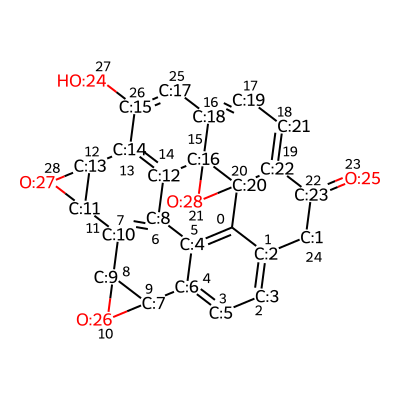

In [37]:
# --- Create RDKit mol from SMILES
mol = Chem.MolFromSmiles(data[0][mol_name])
mol

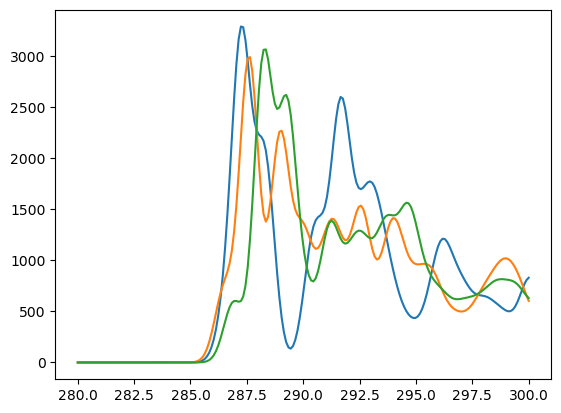

In [38]:
# --- Plot similar chemical environment atoms to check
# --- if dictionary is right
x = np.linspace(280, 300, num=200, endpoint=True)

plt.plot(x, data[1][mol_name]['12'])
plt.plot(x, data[1][mol_name]['11'])
plt.plot(x, data[1][mol_name]['8'])
plt.show()

In [ ]:
bad_mols = ['0','2','7','9','10','12','14','15','16','17','18','22','23','27','31','32','33','36',
            '37','38','41','42','43','46','47','48','50','51','52','53','54','55','56','59','61',
            '62','63','65','67','68','71','74','75','76','78','79','81','84','85','88','89','90']

print(len(bad_mols))

52


In [156]:
good_mols = ['1','3','4','5','6','8','11','13','19','20','21','24','25','26','28','29','30','34',
             '35','39','40','44','45','49','57','58','60','64','66','69','70','72','73','77',
             '80','82','83','86','87']

print(len(good_mols))

39
